In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torchmetrics
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
torch.manual_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
train_all = datasets.MNIST(root="../datasets/mnist", train=True, transform=transforms.ToTensor(), download=True)
test_ds = datasets.MNIST(root="../datasets/mnist", train=False, transform=transforms.ToTensor())

train_ds, val_ds = random_split(train_all, lengths=[54000, 6000], generator=torch.Generator().manual_seed(42))

print("Train set:", len(train_ds))
print("Val set  :", len(val_ds))
print("Test set :", len(test_ds))

Train set: 54000
Val set  : 6000
Test set : 10000


### Defining the DataLoader

In [3]:
train_loader = DataLoader(dataset=train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_ds, batch_size=64, shuffle=False)

In [4]:
train_counter = Counter()
for _, labels in train_loader:
    train_counter.update(labels.tolist())
print("Training label distribution:")
print(sorted(train_counter.items()))
 
val_counter = Counter()
for _, labels in val_loader:
    val_counter.update(labels.tolist())
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    
test_counter = Counter()
for _, labels in test_loader:
    test_counter.update(labels.tolist())
print("\nTest label distribution:")
print(sorted(test_counter.items()))

Training label distribution:
[(0, 5340), (1, 6076), (2, 5383), (3, 5509), (4, 5246), (5, 4903), (6, 5308), (7, 5609), (8, 5254), (9, 5372)]

Validation label distribution:
[(0, 583), (1, 666), (2, 575), (3, 622), (4, 596), (5, 518), (6, 610), (7, 656), (8, 597), (9, 577)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


### Visualize the Dataset

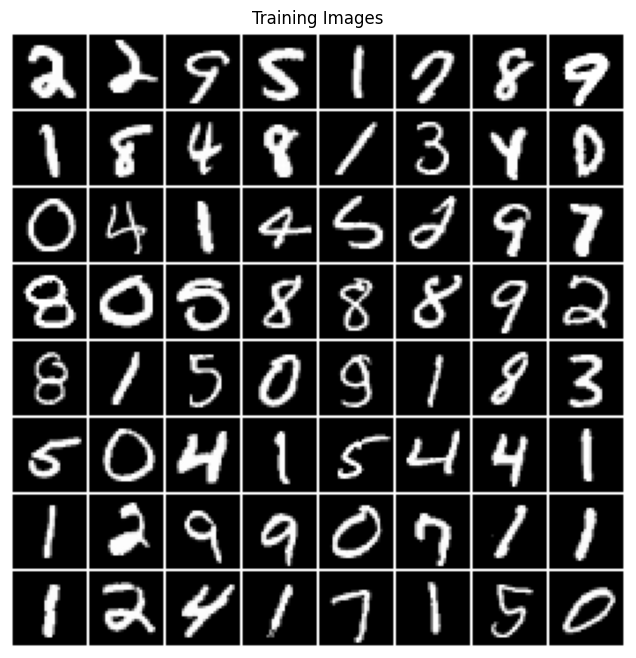

In [5]:
for images, _ in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)
))
plt.show()

### Zero-Rule baseline (Majority class classifier)

In [6]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f}")

Majority class: 1
Accuracy when always predicting the majority class: 0.11


### Design the Model

In [7]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(25, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits
    
    def predict(self, x):
        self = self.eval()
        with torch.inference_mode():
            return self(x)

model = PyTorchMLP(num_features=784, num_classes=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
model

PyTorchMLP(
  (all_layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=10, bias=True)
  )
)

### Train the Model

In [8]:
def compute_accuracy(model, dataloader):
    correct = 0
    total_samples = 0  
    for x_batch, y_batch in dataloader:
        logits = model.predict(x_batch)
        y_preds = torch.argmax(logits, dim=1)
        compare = y_batch == y_preds
        correct += torch.sum(compare)
        total_samples += len(compare)
    return correct / total_samples

In [9]:
history = {
    'loss': [],
    'train_acc': [],
    'val_acc': [],
}

def train(model, optimizer, num_epochs):
    for epoch in range(num_epochs):
        epoch_loss = 0.00
        model = model.train()        
        for batch_idx, (features, labels) in enumerate(train_loader):
            # forward pass
            logits = model(features)
            loss = F.cross_entropy(logits, labels)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()        
            optimizer.step()
            
            epoch_loss += abs(loss.item())
            history['loss'].append(loss.item())
            if not batch_idx % 250:
                print(f' -> batch {batch_idx+1:03d} | loss: {loss:.2f}')
            
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}',
            f'| train_acc: {train_acc:.2f} | val_acc: {val_acc:.2f}',
        )
 
train(model, optimizer, num_epochs=10)

 -> batch 001 | loss: 2.32
 -> batch 251 | loss: 0.54
 -> batch 501 | loss: 0.54
 -> batch 751 | loss: 0.30
Epoch: 001/010 | epoch_loss: 647.42 | train_acc: 0.90 | val_acc: 0.90
 -> batch 001 | loss: 0.46
 -> batch 251 | loss: 0.28
 -> batch 501 | loss: 0.40
 -> batch 751 | loss: 0.26
Epoch: 002/010 | epoch_loss: 255.33 | train_acc: 0.93 | val_acc: 0.92
 -> batch 001 | loss: 0.25
 -> batch 251 | loss: 0.18
 -> batch 501 | loss: 0.36
 -> batch 751 | loss: 0.44
Epoch: 003/010 | epoch_loss: 198.90 | train_acc: 0.94 | val_acc: 0.93
 -> batch 001 | loss: 0.31
 -> batch 251 | loss: 0.19
 -> batch 501 | loss: 0.09
 -> batch 751 | loss: 0.12
Epoch: 004/010 | epoch_loss: 162.88 | train_acc: 0.95 | val_acc: 0.94
 -> batch 001 | loss: 0.24
 -> batch 251 | loss: 0.04
 -> batch 501 | loss: 0.10
 -> batch 751 | loss: 0.27
Epoch: 005/010 | epoch_loss: 138.13 | train_acc: 0.96 | val_acc: 0.95
 -> batch 001 | loss: 0.32
 -> batch 251 | loss: 0.05
 -> batch 501 | loss: 0.25
 -> batch 751 | loss: 0.34
Ep

### Save and Load the Model

In [10]:
# save the model
# MODEL_PATH = "pytorch.pt"
# torch.save(pytorch_model.state_dict(), MODEL_PATH)

# load the model
# model = PyTorchMLP(num_features=784, num_classes=10)
# model.load_state_dict(torch.load(MODEL_PATH))
# model.eval()

### Evaluate the Model

In [11]:
train_acc = compute_accuracy(model, train_loader)
val_acc = compute_accuracy(model, val_loader)
test_acc = compute_accuracy(model, test_loader)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Val Accuracy  : {val_acc:.2f}")
print(f"Test Accuracy : {test_acc:.2f}")

Train Accuracy: 0.97
Val Accuracy  : 0.96
Test Accuracy : 0.97


### Make Prediction

In [12]:
X_tests = []
y_trues = []
y_preds = []

for x_batch, y_batch in test_loader:
    probas = model.predict(x_batch)
    preds = np.argmax(probas, axis=1)
    X_tests.append(x_batch)
    y_trues.append(y_batch)
    y_preds.append(preds)
    
X_tests = torch.cat(X_tests, dim=0)
y_trues = torch.cat(y_trues, dim=0)
y_preds = torch.cat(y_preds, dim=0)

# remove the color dimention
X_tests = X_tests.squeeze(1)

correct_indices = []
incorrect_indices = []
for i in range(len(y_preds)):
    if y_preds[i] == y_trues[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)

### Visualize Confusion Matrix

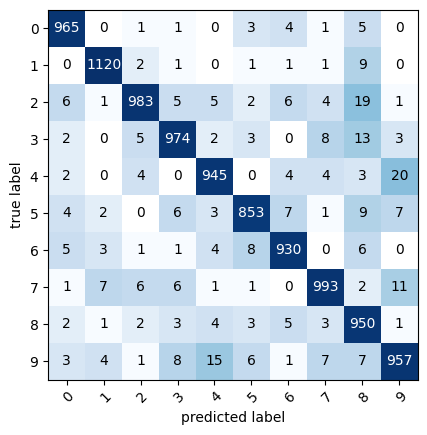

In [13]:
import matplotlib
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

class_dict = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}
cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in test_loader:
    with torch.inference_mode():
        pred = model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat_str = cmat_tensor.numpy()
fig, ax = plot_confusion_matrix(
    conf_mat=cmat_str,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()

### Visualize Training Metrices

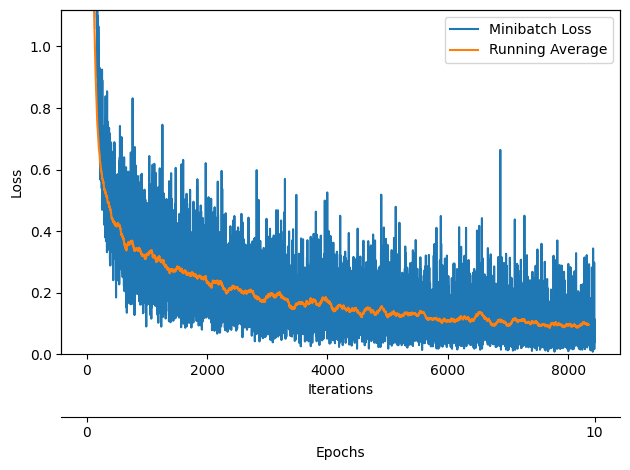

In [14]:
from modules.plotting_helper import plot_training_loss

epochs = len(history['train_acc'])
plot_training_loss(minibatch_loss_list=history['loss'],
                   num_epochs=epochs,
                   iter_per_epoch=len(history['loss'])//epochs)

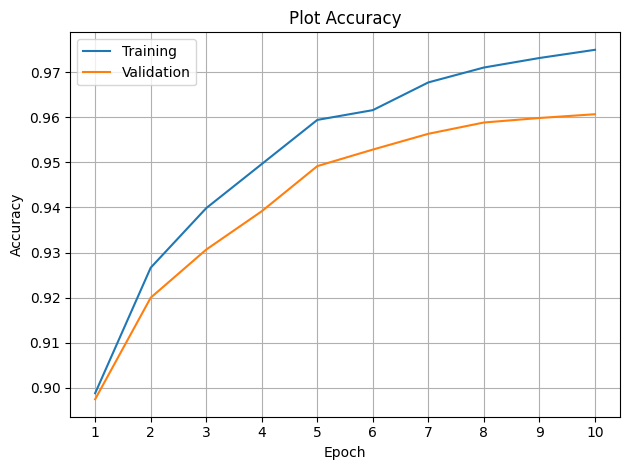

In [15]:
metric_name = "Accuracy"
plt.plot(np.arange(1, epochs+1), history['train_acc'], label=f'Training')
plt.plot(np.arange(1, epochs+1), history['val_acc'], label=f'Validation')
plt.xticks(np.arange(1, epochs+1, 1))
plt.title(f'Plot {metric_name}')
plt.xlabel('Epoch')
plt.ylabel(metric_name)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Visualize the Prediction

Correct Predictions: 9670


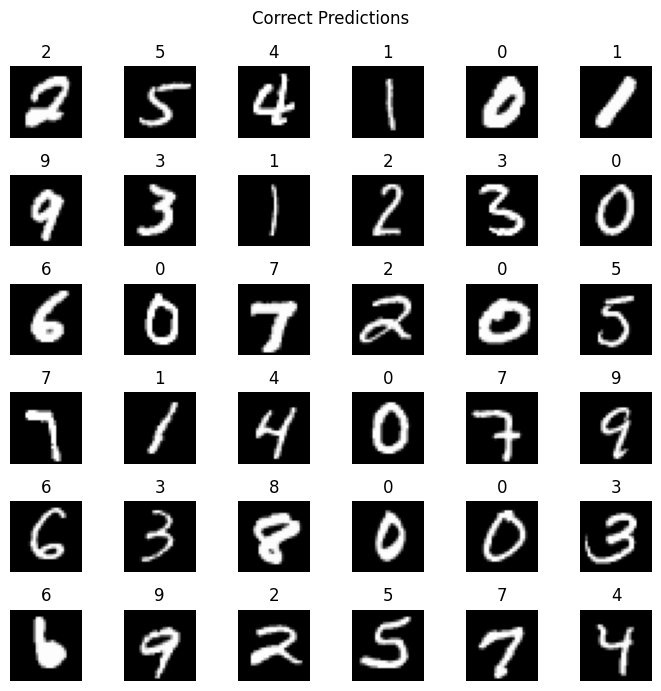

In [16]:
print("Correct Predictions:", len(correct_indices))

plt.figure(figsize=(7,7))
for i in range(36):
    idx = random.choice(correct_indices)
    plt.subplot(6,6,i+1)
    plt.imshow(X_tests[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"{y_preds[idx]}")
plt.suptitle("Correct Predictions")
plt.tight_layout()
plt.show()

Incorrect Predictions: 330


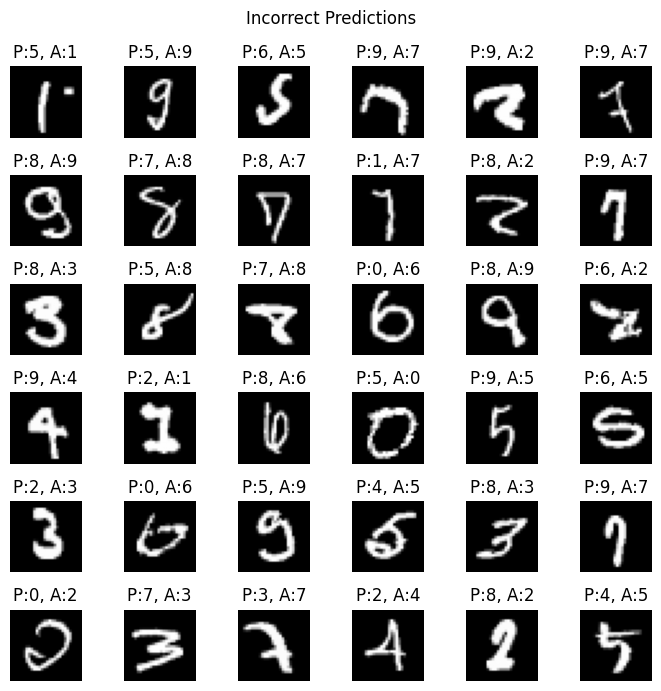

In [17]:
print("Incorrect Predictions:", len(incorrect_indices))

plt.figure(figsize=(7,7))
for i in range(36):
    idx = random.choice(incorrect_indices)
    plt.subplot(6,6,i+1)
    plt.imshow(X_tests[idx], cmap='gray')
    plt.axis('off')
    plt.title(f"P:{y_preds[idx]}, A:{y_trues[idx]}")
plt.suptitle("Incorrect Predictions") 
plt.tight_layout()
plt.show()